# Cell type annotation from marker genes

## Documentation

https://decoupler-py.readthedocs.io/en/latest/notebooks/cell_annotation.html

## Loading packages

In [2]:
#!pip install omnipath
#!pip3 install leidenalg
#!pip install decoupler

import scanpy as sc
import decoupler as dc
import numpy as np

## Single-cell processing

### Loading the data-set

In [168]:
#adata = sc.read("/storage/users/sac43cg/res_Samantha_1/outs/per_sample_outs/time_adata.h5ad")
#adata = sc.read("/storage/users/sac43cg/res_Samantha_1/outs/per_sample_outs/clustered_adata.h5ad")
adata = sc.read("/storage/users/sac43cg/res_Samantha_1/outs/per_sample_outs/annotated_adata.h5ad")
adata

#adata = sc.datasets.pbmc3k()
#adata

/home2/lumpi/miniconda3/envs/sc_cell/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home2/lumpi/miniconda3/envs/sc_cell/lib/python3.9/site-packages/anndata/_core/anndata.py:1900: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 10594 × 2000
    obs: 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pct_cmo', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'leiden', 'leiden_combined', 'louvain', 'louvain_combined', 'index', 'IDs'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'CMO', 'gene_symbol', 'mito', 'ribo', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'condition_colors', 'hvg', 'leiden', 'leiden_combined_colors', 'log1p', 'louvain', 'louvain_combined_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [137]:
adata.var_names

Index(['HES4', 'ISG15', '', 'C1QTNF12', 'TNFRSF9', 'LINC01647', 'TNFRSF8',
       'KAZN', 'SLC25A34-AS1', 'TMEM82',
       ...
       'FGF13', 'LINC00632', '', 'GABRA3', 'ZNF185', 'PNMA5', 'BGN', 'ATP2B3',
       'L1CAM', 'MT-CO2'],
      dtype='object', length=2000)

### QC, projection and clustering

this was already done in script 03_QC..jynb

In [138]:
# Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

/home2/lumpi/miniconda3/envs/sc_cell/lib/python3.9/site-packages/anndata/_core/anndata.py:1900: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home2/lumpi/miniconda3/envs/sc_cell/lib/python3.9/site-packages/anndata/_core/anndata.py:1900: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [139]:
# Annotate the group of mitochondrial genes as 'mt'
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [133]:
# Filter cells following standard QC criteria.
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 20, :]

In [140]:
# Normalize the data
#sc.pp.normalize_total(adata, target_sum=1e4)
#sc.pp.log1p(adata)

# Identify the 2000 most highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.1)

# Filter higly variable genes
adata.raw = adata
adata = adata[:, adata.var.highly_variable]

/home2/lumpi/miniconda3/envs/sc_cell/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:215: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


In [126]:
# Regress and scale the data
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

/home2/lumpi/miniconda3/envs/sc_cell/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:619: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if keys[0] in adata.obs_keys() and is_categorical_dtype(adata.obs[keys[0]]):


#### Then we group cells based on the similarity of their transcription profiles. To visualize the communities we perform UMAP reduction.

also already done in te scrit 04_PCA_UMAP

/home2/lumpi/miniconda3/envs/sc_cell/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home2/lumpi/miniconda3/envs/sc_cell/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home2/lumpi/miniconda3/envs/sc_cell/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


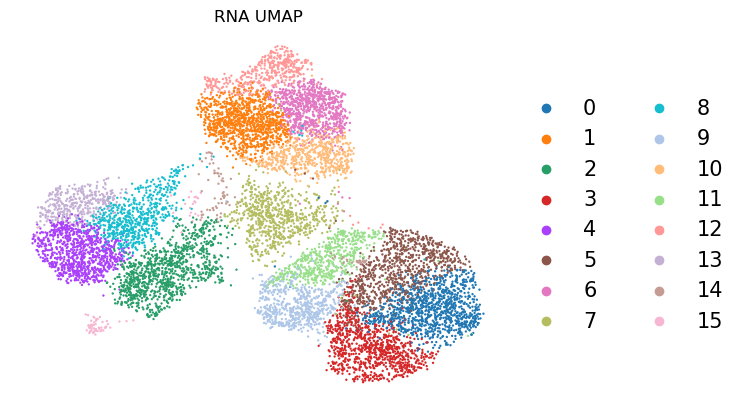

In [169]:
# Generate PCA features
sc.tl.pca(adata, svd_solver='arpack')

# Compute distances in the PCA space, and find cell neighbors
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

# Generate UMAP features
sc.tl.umap(adata)

# Run leiden clustering algorithm
sc.tl.leiden(adata)

# Visualize
sc.pl.umap(adata, color='leiden', title='RNA UMAP',
           frameon=False, legend_fontweight='normal', legend_fontsize=15)

### Marker genes

To annotate single cell clusters, we can use cell type specific marker genes. These are genes that are mainly expressed exclusively by a specific cell type, making them useful to distinguish heterogeneous groups of cells. Marker genes were discovered and annotated in previous studies and there are some resources that collect and curate them.

Omnipath is one of the largest available databases of curated prior knowledge. Among its resources, there is PanglaoDB, a database of cell type markers, which can be easily accessed using a wrapper to Omnipath from decoupler.

In [170]:
# Query Omnipath and get PanglaoDB
markers = dc.get_resource('PanglaoDB')
markers

,genesymbol,canonical_marker,cell_type,germ_layer,human,human_sensitivity,human_specificity,mouse,mouse_sensitivity,mouse_specificity,ncbi_tax_id,organ,ubiquitiousness
0,CTRB1,False,Enterocytes,Endoderm,True,0.0,0.00439422,True,0.00331126,0.0204803,9606,GI tract,0.017
1,CTRB1,True,Acinar cells,Endoderm,True,1.0,0.000628931,True,0.957143,0.0159201,9606,Pancreas,0.017
2,KLK1,True,Endothelial cells,Mesoderm,True,0.0,0.00841969,True,0.0,0.0149153,9606,Vasculature,0.013
3,KLK1,False,Goblet cells,Endoderm,True,0.588235,0.00503937,True,0.903226,0.0124084,9606,GI tract,0.013
4,KLK1,False,Epithelial cells,Mesoderm,True,0.0,0.00823306,True,0.225806,0.0137585,9606,Epithelium,0.013
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8456,SLC14A1,True,Urothelial cells,Mesoderm,True,0.0,0.0181704,True,0.0,0.0,9606,Urinary bladder,0.008
8457,UPK3A,True,Urothelial cells,Mesoderm,True,0.0,0.0,True,0.0,0.0,9606,Urinary bladder,0.0
8458,UPK1A,True,Urothelial cells,Mesoderm,True,0.0,0.0,True,0.0,0.0,9606,Urinary bladder,0.0
8459,UPK2,True,Urothelial cells,Mesoderm,True,0.0,0.0,True,0.0,0.0,9606,Urinary bladder,0.0


Since our data-set is from human cells, and we want best quality of the markers, we can filter by canonical_marker and human:

In [171]:
# Filter by canonical_marker and human
markers = markers[(markers['human']=='True')&(markers['canonical_marker']=='True')]

# Remove duplicated entries
markers = markers[~markers.duplicated(['cell_type', 'genesymbol'])]
markers

,genesymbol,canonical_marker,cell_type,germ_layer,human,human_sensitivity,human_specificity,mouse,mouse_sensitivity,mouse_specificity,ncbi_tax_id,organ,ubiquitiousness
1,CTRB1,True,Acinar cells,Endoderm,True,1.0,0.000628931,True,0.957143,0.0159201,9606,Pancreas,0.017
2,KLK1,True,Endothelial cells,Mesoderm,True,0.0,0.00841969,True,0.0,0.0149153,9606,Vasculature,0.013
5,KLK1,True,Principal cells,Mesoderm,True,0.0,0.00814536,True,0.285714,0.0140583,9606,Kidney,0.013
6,KLK1,True,Acinar cells,Endoderm,True,0.833333,0.00503145,True,0.314286,0.0128263,9606,Pancreas,0.013
7,KLK1,True,Plasmacytoid dendritic cells,Mesoderm,True,0.0,0.00820189,True,1.0,0.0129136,9606,Immune system,0.013
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8456,SLC14A1,True,Urothelial cells,Mesoderm,True,0.0,0.0181704,True,0.0,0.0,9606,Urinary bladder,0.008
8457,UPK3A,True,Urothelial cells,Mesoderm,True,0.0,0.0,True,0.0,0.0,9606,Urinary bladder,0.0
8458,UPK1A,True,Urothelial cells,Mesoderm,True,0.0,0.0,True,0.0,0.0,9606,Urinary bladder,0.0
8459,UPK2,True,Urothelial cells,Mesoderm,True,0.0,0.0,True,0.0,0.0,9606,Urinary bladder,0.0


For this example we will use these markers, but any collection of genes could be used. To see the list of available resources inside Omnipath, run

## Enrichment with Over Representation Analysis (ORA)

To infer functional enrichment scores we will run the Over Representation Analysis (ora) method. As input data it accepts an expression matrix (decoupler.run_ora) or the results of differential expression analysis (decoupler.run_ora_df). For the former, by default the top 5% of expressed genes by sample are selected as the set of interest (S*), and for the latter a user-defined significance filtering can be used. Once we have S*, it builds a contingency table using set operations for each set stored in the gene set resource being used (net). Using the contingency table, ora performs a one-sided Fisher exact test to test for significance of overlap between sets. The final score is obtained by log-transforming the obtained p-values, meaning that higher values are more significant.

b39a8108f20c4f20b98d731dd3f6ae99
https://decoupler-py.readthedocs.io/en/latest/notebooks/cell_annotation.html

We can run ora with a simple one-liner:



In [172]:
adata


AnnData object with n_obs × n_vars = 10594 × 2000
    obs: 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pct_cmo', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'leiden', 'leiden_combined', 'louvain', 'louvain_combined', 'index', 'IDs'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'CMO', 'gene_symbol', 'mito', 'ribo', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'condition_colors', 'hvg', 'leiden', 'leiden_combined_colors', 'log1p', 'louvain', 'louvain_combined_colors', 'neighbors', 'pca', 'umap', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [173]:
adata.var.gene_symbol

HES4            HES4
ISG15          ISG15
                    
C1QTNF12    C1QTNF12
TNFRSF9      TNFRSF9
              ...   
PNMA5          PNMA5
BGN              BGN
ATP2B3        ATP2B3
L1CAM          L1CAM
MT-CO2        MT-CO2
Name: gene_symbol, Length: 2000, dtype: category
Categories (1611, object): ['', 'AASS', 'ABCA1', 'ABCC8', ..., 'ZNF679', 'ZNF804A', 'ZNF827', 'ZSWIM6']

In [174]:
markers

,genesymbol,canonical_marker,cell_type,germ_layer,human,human_sensitivity,human_specificity,mouse,mouse_sensitivity,mouse_specificity,ncbi_tax_id,organ,ubiquitiousness
1,CTRB1,True,Acinar cells,Endoderm,True,1.0,0.000628931,True,0.957143,0.0159201,9606,Pancreas,0.017
2,KLK1,True,Endothelial cells,Mesoderm,True,0.0,0.00841969,True,0.0,0.0149153,9606,Vasculature,0.013
5,KLK1,True,Principal cells,Mesoderm,True,0.0,0.00814536,True,0.285714,0.0140583,9606,Kidney,0.013
6,KLK1,True,Acinar cells,Endoderm,True,0.833333,0.00503145,True,0.314286,0.0128263,9606,Pancreas,0.013
7,KLK1,True,Plasmacytoid dendritic cells,Mesoderm,True,0.0,0.00820189,True,1.0,0.0129136,9606,Immune system,0.013
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8456,SLC14A1,True,Urothelial cells,Mesoderm,True,0.0,0.0181704,True,0.0,0.0,9606,Urinary bladder,0.008
8457,UPK3A,True,Urothelial cells,Mesoderm,True,0.0,0.0,True,0.0,0.0,9606,Urinary bladder,0.0
8458,UPK1A,True,Urothelial cells,Mesoderm,True,0.0,0.0,True,0.0,0.0,9606,Urinary bladder,0.0
8459,UPK2,True,Urothelial cells,Mesoderm,True,0.0,0.0,True,0.0,0.0,9606,Urinary bladder,0.0


In [175]:
adata.var_names = adata.var.gene_symbol

/home2/lumpi/miniconda3/envs/sc_cell/lib/python3.9/site-packages/anndata/_core/anndata.py:949: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['HES4', 'ISG15', '', 'C1QTNF12', 'TNFRSF9']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")


In [176]:
# Filter out rows with empty strings in var_names
adata = adata[:, adata.var_names != ""]

In [177]:
adata.raw = adata

/home2/lumpi/miniconda3/envs/sc_cell/lib/python3.9/site-packages/anndata/_core/anndata.py:1900: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [178]:
dc.run_ora(
    mat=adata,
    net=markers,
    source='cell_type',
    target='genesymbol',
    min_n=6,
    verbose=True
)

Running ora on mat with 10594 samples and 1615 targets for 63 sources.


100%|██████████| 10594/10594 [00:12<00:00, 842.11it/s]


The obtained scores (-log10(p-value))(ora_estimate) and p-values (ora_pvals) are stored in the .obsm key:

In [180]:
adata.obsm['ora_estimate']

source,Acinar cells,Adipocytes,Alpha cells,Astrocytes,B cells,B cells naive,Basophils,Bergmann glia,Beta cells,Cardiomyocytes,...,Principal cells,Proximal tubule cells,Pulmonary alveolar type I cells,Pulmonary alveolar type II cells,Satellite cells,Schwann cells,Sertoli cells,Smooth muscle cells,T cells,Tanycytes
AAACCCAGTAGGCTCC-1,1.322898,1.129358,-0.0,3.060396,3.618951,-0.0,1.322898,1.552656,-0.00000,1.175942,...,1.618736,1.618736,1.495530,-0.0,1.552656,-0.000000,1.552656,-0.000000,1.400351,-0.00000
AAACCCAGTCGCAACC-1,1.322898,2.576891,-0.0,3.060396,-0.000000,-0.0,2.982357,1.552656,1.49553,4.379109,...,1.618736,1.618736,1.495530,-0.0,-0.000000,1.445243,-0.000000,-0.000000,-0.000000,-0.00000
AAACCCATCCACAAGT-1,2.982357,1.129358,-0.0,4.986512,1.618736,-0.0,1.322898,3.473967,1.49553,2.674068,...,3.618951,-0.000000,5.451995,-0.0,-0.000000,1.445243,1.552656,-0.000000,1.400351,1.49553
AAACGCTTCACTACGA-1,1.322898,2.576891,-0.0,3.060396,1.618736,-0.0,2.982357,3.473967,-0.00000,1.175942,...,3.618951,-0.000000,3.350172,-0.0,1.552656,1.445243,1.552656,-0.000000,1.400351,-0.00000
AAACGCTTCAGCCTCT-1,-0.000000,2.576891,-0.0,1.359822,-0.000000,-0.0,1.322898,1.552656,-0.00000,1.175942,...,-0.000000,-0.000000,-0.000000,-0.0,1.552656,-0.000000,-0.000000,-0.000000,1.400351,-0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTACTGTCATTACTC-1,1.322898,1.129358,-0.0,1.359822,-0.000000,-0.0,1.322898,1.552656,1.49553,1.175942,...,1.618736,-0.000000,1.495530,-0.0,-0.000000,-0.000000,1.552656,-0.000000,-0.000000,1.49553
TTTCACAGTGATATAG-1,2.982357,2.576891,-0.0,3.060396,-0.000000,-0.0,1.322898,1.552656,-0.00000,1.175942,...,-0.000000,1.618736,1.495530,-0.0,-0.000000,1.445243,-0.000000,-0.000000,1.400351,-0.00000
TTTCACATCGATGCAT-1,1.322898,1.129358,-0.0,3.060396,-0.000000,-0.0,2.982357,1.552656,-0.00000,2.674068,...,-0.000000,1.618736,3.350172,-0.0,-0.000000,1.445243,-0.000000,-0.000000,-0.000000,1.49553
TTTCATGTCCCTCTAG-1,1.322898,4.227833,-0.0,3.060396,-0.000000,-0.0,1.322898,1.552656,-0.00000,2.674068,...,1.618736,1.618736,3.350172,-0.0,1.552656,-0.000000,1.552656,-0.000000,1.400351,1.49553


## Visualization

To visualize the obtained scores, we can re-use many of scanpy’s plotting functions. First though, we need to extract them from the adata object.

In [181]:
acts = dc.get_acts(adata, obsm_key='ora_estimate')

# We need to remove inf and set them to the maximum value observed for pvals=0
acts_v = acts.X.ravel()
max_e = np.nanmax(acts_v[np.isfinite(acts_v)])
acts.X[~np.isfinite(acts.X)] = max_e

acts

/home2/lumpi/miniconda3/envs/sc_cell/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 10594 × 63
    obs: 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pct_cmo', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'leiden', 'leiden_combined', 'louvain', 'louvain_combined', 'index', 'IDs'
    uns: 'condition_colors', 'hvg', 'leiden', 'leiden_combined_colors', 'log1p', 'louvain', 'louvain_combined_colors', 'neighbors', 'pca', 'umap', 'leiden_colors'
    obsm: 'X_pca', 'X_umap', 'ora_estimate', 'ora_pvals'

dc.get_acts returns a new AnnData object which holds the obtained activities in its .X attribute, allowing us to re-use many scanpy functions, for example:

/home2/lumpi/miniconda3/envs/sc_cell/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home2/lumpi/miniconda3/envs/sc_cell/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home2/lumpi/miniconda3/envs/sc_cell/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


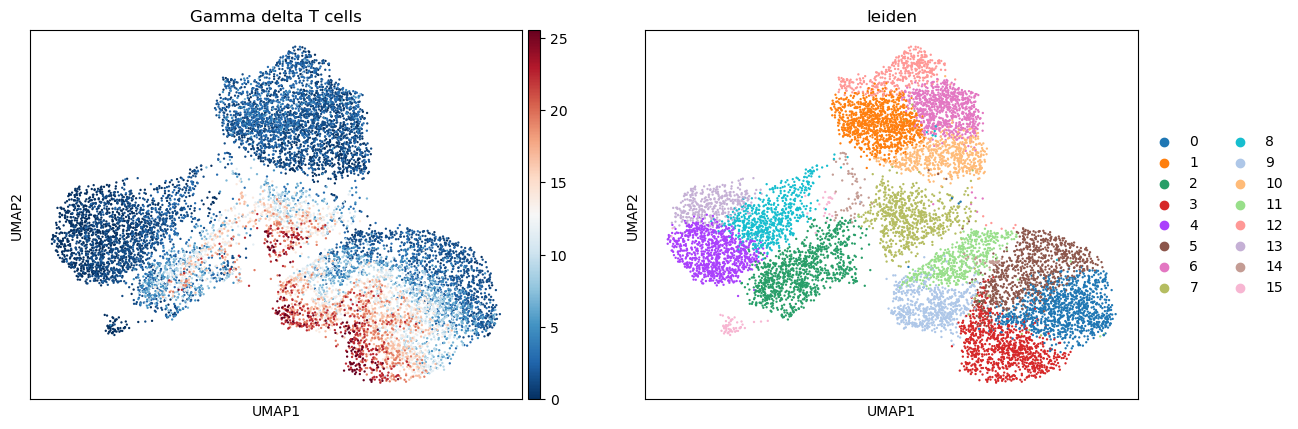

/home2/lumpi/miniconda3/envs/sc_cell/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:770: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[groupby]):
/home2/lumpi/miniconda3/envs/sc_cell/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home2/lumpi/miniconda3/envs/sc_cell/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


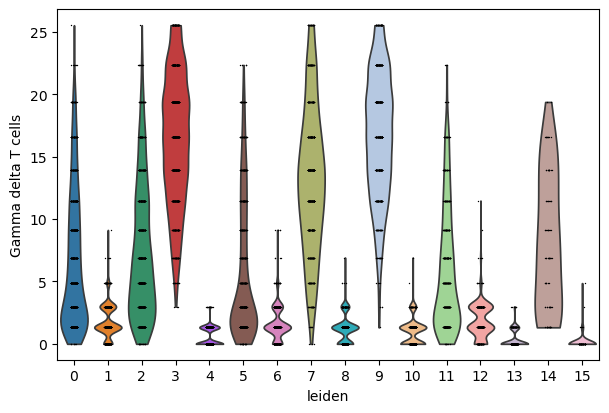

In [183]:
sc.pl.umap(acts, color=['Gamma delta T cells', 'leiden'], cmap='RdBu_r')
sc.pl.violin(acts, keys=['Gamma delta T cells'], groupby='leiden')

## Annotation

With decoupler we can also identify which are the top predicted cell types per cluster using the function dc.rank_sources_groups. Here, it identifies “marker” cell types per cluster using same statistical tests available in scanpy’s scanpy.tl.rank_genes_groups.

In [184]:
df = dc.rank_sources_groups(acts, groupby='leiden', reference='rest', method='t-test_overestim_var')
df

,group,reference,names,statistic,meanchange,pvals,pvals_adj
0,0,rest,Beta cells,20.275552,0.847589,2.050020e-83,1.354724e-82
1,0,rest,Plasmacytoid dendritic cells,18.178569,0.558334,1.294802e-68,5.438170e-68
2,0,rest,Melanocytes,17.376017,0.573394,3.035406e-63,1.062392e-62
3,0,rest,Mast cells,13.002871,0.943792,3.348190e-37,6.804387e-37
4,0,rest,Mammary epithelial cells,11.009907,0.957868,2.100260e-27,3.675454e-27
...,...,...,...,...,...,...,...
1003,9,rest,Pulmonary alveolar type I cells,-17.009660,-1.276827,1.087872e-56,9.652539e-56
1004,9,rest,Hepatic stellate cells,-17.993248,-2.006950,2.254293e-61,2.367008e-60
1005,9,rest,Fibroblasts,-20.400562,-3.115289,5.807126e-73,9.146224e-72
1006,9,rest,Microglia,-21.256996,-1.406375,1.442443e-77,3.029131e-76


We can then extract the top 3 predicted cell types per cluster:

In [185]:
n_ctypes = 3
ctypes_dict = df.groupby('group').head(n_ctypes).groupby('group')['names'].apply(lambda x: list(x)).to_dict()
ctypes_dict

{'0': ['Beta cells', 'Plasmacytoid dendritic cells', 'Melanocytes'],
 '1': ['Enterocytes', 'B cells', 'Luminal epithelial cells'],
 '10': ['B cells', 'Sertoli cells', 'Microglia'],
 '11': ['Mast cells', 'Beta cells', 'Astrocytes'],
 '12': ['Astrocytes', 'Principal cells', 'Macrophages'],
 '13': ['Osteoblasts', 'Osteoclasts', 'Acinar cells'],
 '14': ['Enterocytes', 'Satellite cells', 'Alpha cells'],
 '15': ['Melanocytes', 'Plasmacytoid dendritic cells', 'Epsilon cells'],
 '2': ['Osteoblasts', 'Hepatic stellate cells', 'Pancreatic stellate cells'],
 '3': ['Gamma delta T cells', 'Germ cells', 'Oligodendrocytes'],
 '4': ['Fibroblasts', 'Pancreatic stellate cells', 'Hepatic stellate cells'],
 '5': ['Mammary epithelial cells', 'Cholangiocytes', 'Ductal cells'],
 '6': ['B cells', 'Dendritic cells', 'Luminal epithelial cells'],
 '7': ['Gamma delta T cells', 'Oligodendrocytes', 'Principal cells'],
 '8': ['Hepatic stellate cells', 'Satellite cells', 'Pericytes'],
 '9': ['Gamma delta T cells', 'G

We can visualize the obtained top predicted cell types:

/home2/lumpi/miniconda3/envs/sc_cell/lib/python3.9/site-packages/scanpy/plotting/_matrixplot.py:143: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()
/home2/lumpi/miniconda3/envs/sc_cell/lib/python3.9/site-packages/scanpy/tools/_dendrogram.py:105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[group]):
/home2/lumpi/miniconda3/envs/sc_cell/lib/python3.9/site-packages/scanpy/tools/_dendrogram.py:133: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this 

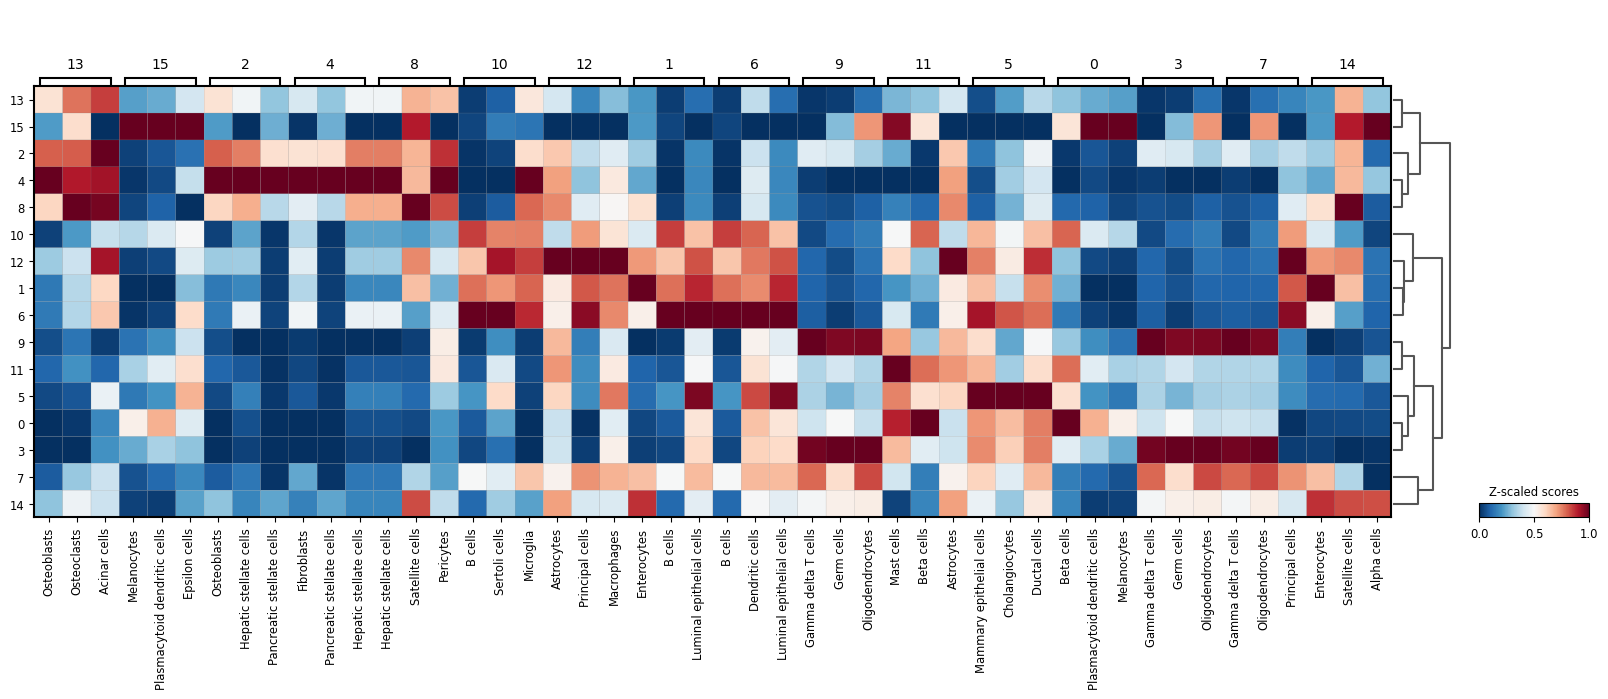

In [186]:
sc.pl.matrixplot(acts, ctypes_dict, 'leiden', dendrogram=True, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='RdBu_r')

/home2/lumpi/miniconda3/envs/sc_cell/lib/python3.9/site-packages/scanpy/plotting/_matrixplot.py:143: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()
/home2/lumpi/miniconda3/envs/sc_cell/lib/python3.9/site-packages/scanpy/tools/_dendrogram.py:105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[group]):
/home2/lumpi/miniconda3/envs/sc_cell/lib/python3.9/site-packages/scanpy/tools/_dendrogram.py:133: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this 

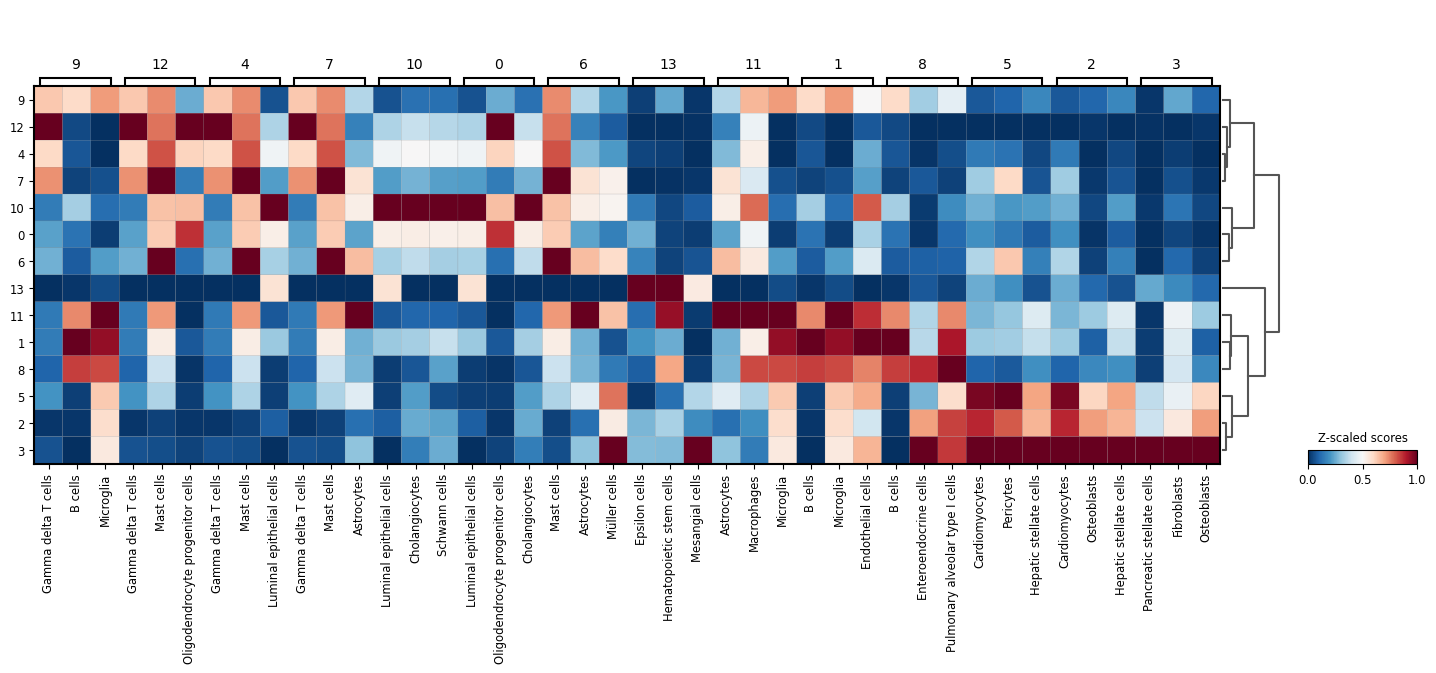

In [156]:
sc.pl.matrixplot(acts, ctypes_dict, 'leiden', dendrogram=True, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='RdBu_r')

From this plot we see that cluster 7 belongs to Platelets, cluster 4 appear to be NK cells, custers 0 and 3 might be T-cells, cluster 2 should be some sort of B cells and that clusters 6,5 and 1 belong to the myeloid lineage.

We can check individual cell types by plotting their distributions:

/home2/lumpi/miniconda3/envs/sc_cell/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:770: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[groupby]):
/home2/lumpi/miniconda3/envs/sc_cell/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home2/lumpi/miniconda3/envs/sc_cell/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(
/home2/lumpi/miniconda3/envs/sc_cell/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

Passing `palette` without assigning

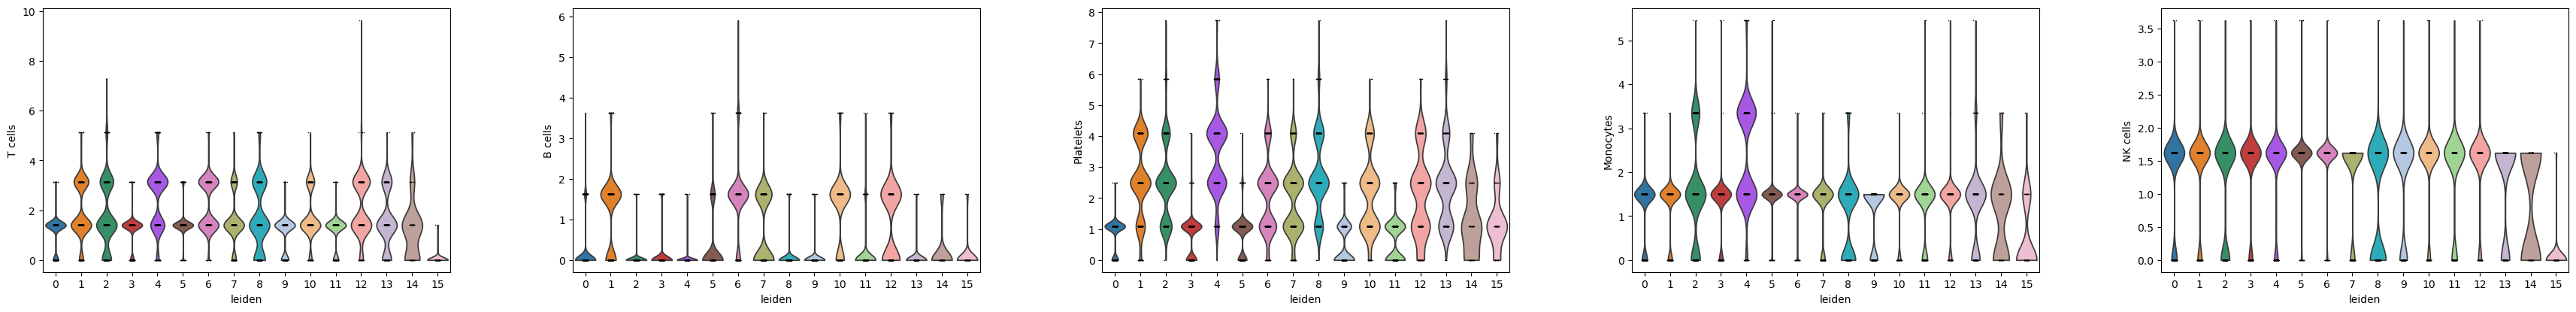

In [187]:
sc.pl.violin(acts, keys=['T cells', 'B cells', 'Platelets', 'Monocytes', 'NK cells'], groupby='leiden')

The final annotation should be done manually based on the assessment of the enrichment results. However, an automatic prediction can be made by assigning the top predicted cell type per cluster. This approach does not require expertise in the tissue being studied but can be prone to errors. Nonetheless it can be useful to generate a first draft, let’s try it:

In [196]:
annotation_dict = df.groupby('group').head(1).set_index('group')['names'].to_dict()
ctypes_dict = df.groupby('group').head(n_ctypes).groupby('group')['names'].apply(lambda x: list(x)).to_dict()
annotation_dict
#annotation_dict = ctypes_dict

{'0': 'Beta cells',
 '1': 'Enterocytes',
 '10': 'B cells',
 '11': 'Mast cells',
 '12': 'Astrocytes',
 '13': 'Osteoblasts',
 '14': 'Enterocytes',
 '15': 'Melanocytes',
 '2': 'Osteoblasts',
 '3': 'Gamma delta T cells',
 '4': 'Fibroblasts',
 '5': 'Mammary epithelial cells',
 '6': 'B cells',
 '7': 'Gamma delta T cells',
 '8': 'Hepatic stellate cells',
 '9': 'Gamma delta T cells'}

In [197]:
ctypes_dict

{'0': ['Beta cells', 'Plasmacytoid dendritic cells', 'Melanocytes'],
 '1': ['Enterocytes', 'B cells', 'Luminal epithelial cells'],
 '10': ['B cells', 'Sertoli cells', 'Microglia'],
 '11': ['Mast cells', 'Beta cells', 'Astrocytes'],
 '12': ['Astrocytes', 'Principal cells', 'Macrophages'],
 '13': ['Osteoblasts', 'Osteoclasts', 'Acinar cells'],
 '14': ['Enterocytes', 'Satellite cells', 'Alpha cells'],
 '15': ['Melanocytes', 'Plasmacytoid dendritic cells', 'Epsilon cells'],
 '2': ['Osteoblasts', 'Hepatic stellate cells', 'Pancreatic stellate cells'],
 '3': ['Gamma delta T cells', 'Germ cells', 'Oligodendrocytes'],
 '4': ['Fibroblasts', 'Pancreatic stellate cells', 'Hepatic stellate cells'],
 '5': ['Mammary epithelial cells', 'Cholangiocytes', 'Ductal cells'],
 '6': ['B cells', 'Dendritic cells', 'Luminal epithelial cells'],
 '7': ['Gamma delta T cells', 'Oligodendrocytes', 'Principal cells'],
 '8': ['Hepatic stellate cells', 'Satellite cells', 'Pericytes'],
 '9': ['Gamma delta T cells', 'G

Once we have selected the top cell type we can finally annotate:

/home2/lumpi/miniconda3/envs/sc_cell/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home2/lumpi/miniconda3/envs/sc_cell/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home2/lumpi/miniconda3/envs/sc_cell/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


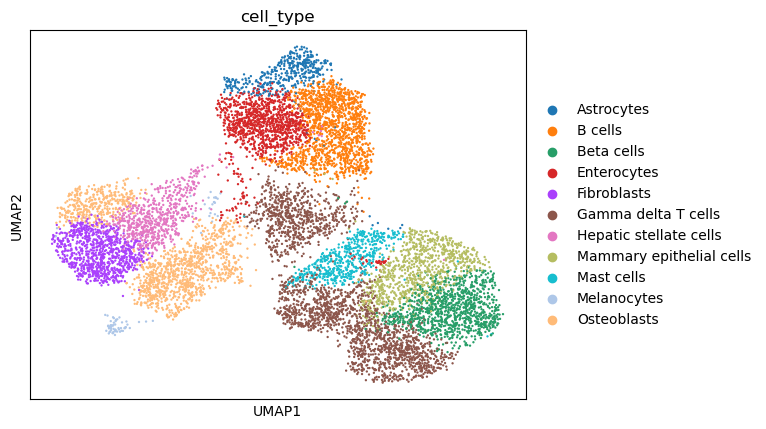

In [198]:
# Add cell type column based on annotation
adata.obs['cell_type'] = [annotation_dict[clust] for clust in adata.obs['leiden']]

# Visualize
sc.pl.umap(adata, color='cell_type')

Compared to the annotation obtained by the scanpy tutorial, it is very similar but there are some errors, highlything the limitation of automatic annotation.

/home2/lumpi/miniconda3/envs/sc_cell/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home2/lumpi/miniconda3/envs/sc_cell/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home2/lumpi/miniconda3/envs/sc_cell/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


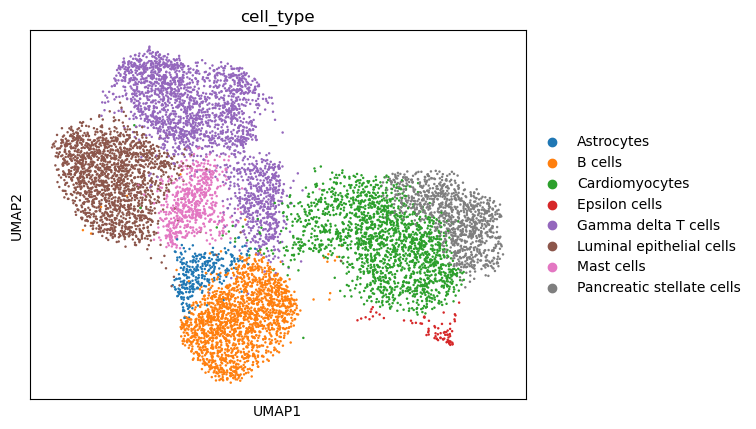

In [162]:
# Add cell type column based on annotation
adata.obs['cell_type'] = [annotation_dict[clust] for clust in adata.obs['leiden']]

# Visualize
sc.pl.umap(adata, color='cell_type')

/home2/lumpi/miniconda3/envs/sc_cell/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home2/lumpi/miniconda3/envs/sc_cell/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home2/lumpi/miniconda3/envs/sc_cell/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


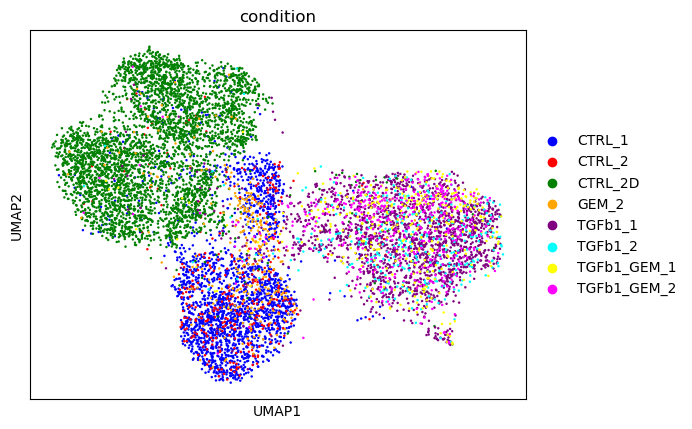

In [163]:
# Visualize
sc.pl.umap(adata, color='condition')